# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 9. Байесовские классификаторы.

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**. 
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком
    * *или* вставив ее в ноутбук посредством `Edit -> Insert Image` при редактировании markdown-ячейки (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). **<font color="red">Неправильно вставленные фотографии могут не передаться при отправке.</font>** Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* **В решениях поясняйте, чем вы пользуетесь**, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.



**Баллы за задание:**

* Задача 1 &mdash; 30 баллов
* Задача 2 &mdash; 28 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [4]:
from sklearn.datasets import fetch_20newsgroups
import random


import warnings
warnings.simplefilter("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

---
### Задача 1.

На занятии мы уже научились классифицировать текстовые сообщения на нормальные и спам. Теперь перед вами стоит более серьезная задача &mdash; построить систему, автоматически классифицирующую поступающие новостные сюжеты на несколько заранее заданных категорий.
 
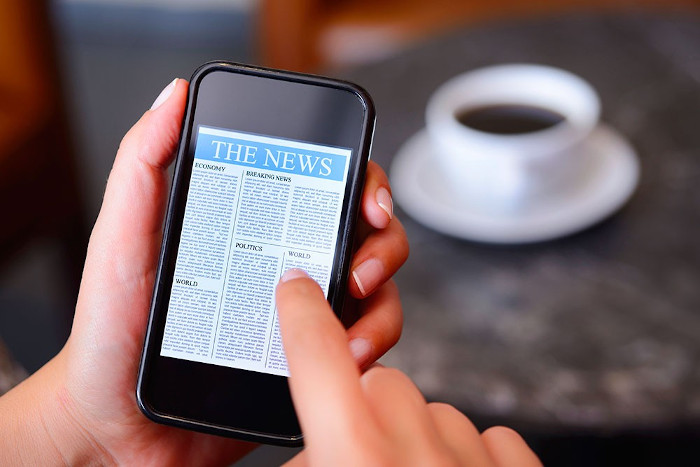



Перед выполнением задачи обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/bayes_classification.html">ноутбук</a> с занятия по классификации.

---

С помощью кода ниже загрузите встроенные в `sklearn` <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups">данные</a>, в которых представлены различные новостные сюжеты, разделенные на 20 тематических групп.

In [5]:
# удаляем заголовки и подписи
remove = ('headers', 'footers')
# зафиксируем зерно случайности
random_state = 42

# Извлекаем обучающую и тестовую части перемешивая случайным образом
train = fetch_20newsgroups(
    subset='train', shuffle=True, random_state=random_state, remove=remove
)
test = fetch_20newsgroups(
    subset='test', shuffle=True, random_state=random_state, remove=remove
)

Названия тематических групп

In [6]:
print(train['target_names'])

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Посмотрим на какое-нибудь сообщение

In [5]:
print(train['target'])

train = pd.DataFrame({'data': train.data, 'target': train.target})
test = pd.DataFrame({'data': test.data, 'target': test.target})

print(train['target'].head(5))

[7 4 4 ... 3 1 8]
0     7
1     4
2     4
3     1
4    14
Name: target, dtype: int64


Индекс тематической группы для каждого сообщения

In [166]:
(train['target'])

0 7
1 4
2 4
3 1
4 14
 ..
11309 13
11310 4
11311 3
11312 1
11313 8
Name: target, Length: 11314, dtype: int64

С помощью методов, изученных в рамках нашего курса, постройте классификатор новостных сюжетов на тематические группы. При построении классификатора **запрещено пользоваться тестовой выборкой**. Для настройки классификатора, например, выбора оптимальных гиперпараметров, можно разделить обучающую выборку на две части &mdash; непосредственно обучающую и валидационную. Первую часть использовать для непосредственного обучения, а вторую &mdash; для настройки, пытаясь по ней оптимизировать качество.

## Решение

Предобработка данных для столбца 'target' не нужна, он уже в числовом виде. Для преобразования текстовых сообщений воспользуемся CountVectorizer с лекции, построив график частоты слов (для настройки гиперпараметров) по первым двум классам.

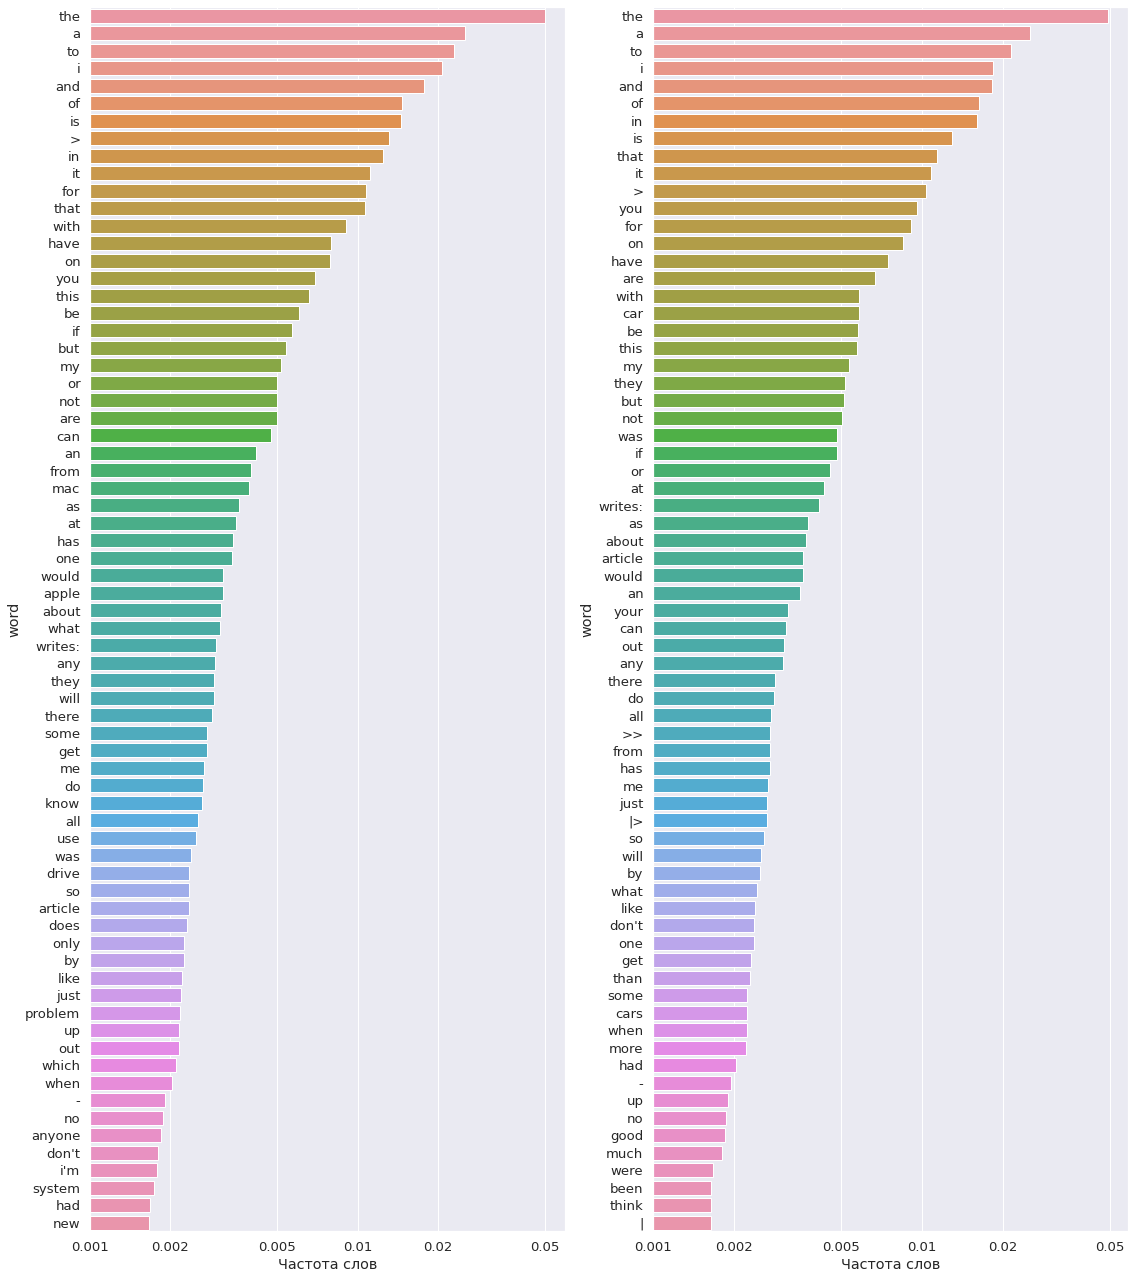

In [167]:
# метки сетки по оси икс
labels = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2]

plt.figure(figsize=(16, 18))

# для каждого класса
for i, label in enumerate(np.unique(train['target'][0:2])):
    # извлечем все сообщения и склеим их
    all_words = ' '.join(
        train[train['target'] == label]['data']
    # приведем к нижнему регистру, удалим точки, разделим на слова
    ).lower().replace('.', '').split()
    # общее количество слов в этом классе
    words_count = len(all_words)
    # print(words_count)

    # посчитаем встречаемость каждого слова и вернем топ-70
    counts = Counter(all_words).most_common(70)
    counts = pd.DataFrame(counts, columns=['word', 'count'])
    
    # print(counts['count'][0])
    plt.subplot(1, 2, i+1)
    sns.barplot(y=counts['word'], x=counts['count']/words_count)
    plt.xscale('log')
    plt.xlabel('Частота слов')
    plt.xticks(labels, labels)
plt.tight_layout()

Разделим тренировочные данные на train и validate. 

In [6]:
data_train, data_valid = train_test_split(train, test_size=0.2)

**Способ 1.**

Попробуем посмотреть на результат при min_df и max_df, подобранных на основе графиков. Из них кажется, что оптимально будет взять min_df = 0.005 и max_df = 0.05. Т.к. в этом пункте мы сразу берем значения гиперпараметров, то будем прогонять сразу на test-данных.

In [193]:
vectorizer = CountVectorizer(min_df=0.005, max_df=0.05)

vec_data_train = vectorizer.fit_transform(data_train['data']).toarray()
vec_data_valid = vectorizer.transform(data_valid['data']).toarray()
vec_data_test = vectorizer.transform(test['data']).toarray()

In [195]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, data_train['target'])

predictions = multinomial_nb.predict(vec_data_test)
print(f'Точность: {accuracy_score(test.target, predictions) :.3}')

Точность: 0.674


Точность довольно невысокая, попробует улучшить результат, перебирая следующие гиперпараметры: $min\_df$, $max\_df$, $\alpha$, где последний - гиперпараметр MultinomialNB. 

**Способ 2.**

Предположим, что гиперпараметры независимы друг от друга, и в цикле переберем отдельно каждый из них, запоминая лучший результат. Ищем значения на валидационных данных.

In [7]:
def linear_cycle(training, validation):
    best_weight = [0, 0, 0]
    best_result = 0
    for mindf in np.arange(0.001, 0.03, 0.001):  
        vec = CountVectorizer(min_df=mindf)

        vec_training = vec.fit_transform(training['data']).toarray()
        vec_validation = vec.transform(validation['data']).toarray()

        multinomial = MultinomialNB()
        multinomial.fit(vec_training, training['target'])

        predict = multinomial.predict(vec_validation)
        result =  accuracy_score(validation.target, predict)

        if (result > best_result):
            best_result = result
            best_weight[0] = mindf
            print(best_result)

    for maxdf in np.arange(0.03, 0.08, 0.001):  
        vec = CountVectorizer(min_df=best_weight[0], max_df=maxdf)

        vec_training = vec.fit_transform(training['data']).toarray()
        vec_validation = vec.transform(validation['data']).toarray()

        multinomial = MultinomialNB()
        multinomial.fit(vec_training, training['target'])

        predict = multinomial.predict(vec_validation)
        result =  accuracy_score(validation.target, predict)

        if (result > best_result):
            best_result = result
            best_weight[1] = maxdf
            print(best_result)
    
    for alpha in np.arange(0, 1, 0.05):  
        vec = CountVectorizer(min_df=best_weight[0], max_df=best_weight[1])

        vec_training = vec.fit_transform(training['data']).toarray()
        vec_validation = vec.transform(validation['data']).toarray()

        multinomial = MultinomialNB(alpha=alpha)
        multinomial.fit(vec_training, training['target'])

        predict = multinomial.predict(vec_validation)
        result =  accuracy_score(validation.target, predict)

        if (result > best_result):
            best_result = result
            best_weight[2] = alpha
            print(best_result)
    return best_weight

In [174]:
print(linear_cycle(data_train, data_valid))

0.799381352187362
0.8064516129032258
0.8077772867874503
0.8086610693769333
0.8095448519664162
0.8099867432611577
0.8117543084401238
0.8139637649138312
0.8174988952717631
0.8179407865665046
0.8183826778612462
[0.001, 0.06900000000000003, 0.2]


Посмотрим результат на тестовых данных.

In [16]:
vectorizer = CountVectorizer(min_df=0.001, max_df=0.069)

vec_data_train = vectorizer.fit_transform(data_train['data']).toarray()
vec_data_valid = vectorizer.transform(data_valid['data']).toarray()
vec_data_test = vectorizer.transform(test['data']).toarray()

multinomial_nb = MultinomialNB(alpha=0.2)
multinomial_nb.fit(vec_data_train, data_train['target'])

predictions = multinomial_nb.predict(vec_data_test)
print(f'Точность: {accuracy_score(test.target, predictions) :.3}')

Точность: 0.736


Точность значительно возросла. 

**Способ 3.**

Попробуем улучшить результат, предполагая, что гиперпараметры могут быть зависимыми. Для этого я реализовал метод имитации отжига. Калибруя алгоритм, прихожу к выводу, что оптимальная начальная температура $T = 10$, уменьшать будем, домножая на 0.9. Менять гиперпараметры будем, выбирая случайные значения в $\epsilon$-окрестности предыдущих, где $\epsilon = 0.005$. В качестве начальных значений возьмем параметры, полученные на предыдущем этапе. Данный алгоритм работает быстрее, чем вложенный цикл. Если у проверяющего возникнут вопросы по моей компетенции в принципе работы метода имитации отжига, буду рад ответить на них после проверки. 

In [8]:
def accuracy_counter(weights, training, validation):
    vec = CountVectorizer(min_df=weights[0], max_df=weights[1])

    vec_training = vec.fit_transform(training['data']).toarray()
    vec_validation = vec.transform(validation['data']).toarray()

    multinomial = MultinomialNB(alpha=weights[2])
    multinomial.fit(vec_training, training['target'])

    predict = multinomial.predict(vec_validation)
    return accuracy_score(validation.target, predict)

In [13]:
def simulated_annealing(temp_step, start_temp, end_temp, training, validation, weights_list):
    best_weights = []
    prev_score = accuracy_counter(weights_list, training, validation)
    t = start_temp #начальная температура
    best_score = 0
    print("Score: ",  prev_score,'\n')

    while t > end_temp:
        prev_weight = weights_list.copy()
        copy_score =  prev_score

        weights_list[0] = random.uniform(weights_list[0] - 0.005, weights_list[0] + 0.005)

        weights_list[1] = random.uniform(weights_list[1] - 0.005, weights_list[1] + 0.005)
        
        weights_list[2] = random.uniform(weights_list[2] - 0.005, weights_list[2] + 0.005)

        while not (weights_list[2] > 0 and weights_list[2] < 1):
            weights_list[2] = random.uniform(weights_list[2] - 0.005, weights_list[2] + 0.005)    

        while not (weights_list[0] < weights_list[1] and weights_list[0] > 0.005 and weights_list[1] < 0.1 and (abs(weights_list[0] - weights_list[1]) > 0.0005)):
            weights_list[0] = random.uniform(weights_list[0] - 0.005, weights_list[0] + 0.005)
            weights_list[1] = random.uniform(weights_list[1] - 0.005, weights_list[1] + 0.005)
          
        print("Temprature: ", t)
        print("Weights: ", weights_list)

        #Обновляем качество
        accuracy = accuracy_counter(weights_list, training, validation)
        desicion = np.exp(-1 * abs(accuracy - copy_score) / t)
        rand = random.random()
        print("DES AND RAND: ", desicion, rand)
        print("FUNC_DIFF: ", accuracy - copy_score)
        if (accuracy - copy_score) >= 0:
            prob = 1
        else:
            prob = desicion

        if prob >= rand:
            prev_score = accuracy
            print("inininin")
        else:
            weights_list = prev_weight.copy()
            print("stay out")

        if accuracy > best_score:
            best_score = accuracy
            best_weights = weights_list.copy()
        print("Score: ",  prev_score,'\n')
        print("------")
        
        t *= temp_step #понижаем температуру


    print("BEST SCORE: ", best_score)
    return best_weights

In [14]:
print((simulated_annealing(0.9, 10, 0.005, data_train, data_valid, [0.001, 0.069, 0.2])))

Score:  0.8197083517454706 

Temprature:  10
Weights:  [0.006054030290623595, 0.06704160705570461, 0.19975055789456791]
DES AND RAND:  0.993481348035297 0.6186249522325048
FUNC_DIFF:  -0.06539991162174108
inininin
Score:  0.7543084401237296 

------
Temprature:  9.0
Weights:  [0.008236510229259057, 0.06759591340977099, 0.19972881298067313]
DES AND RAND:  0.9971073488686528 0.003602174495887067
FUNC_DIFF:  -0.026071586389748158
inininin
Score:  0.7282368537339814 

------
Temprature:  8.1
Weights:  [0.005995266918041628, 0.06308594969126234, 0.1975155407764099]
DES AND RAND:  0.9972215884273 0.451556907902702
FUNC_DIFF:  0.0225364560318162
inininin
Score:  0.7507733097657976 

------
Temprature:  7.29
Weights:  [0.0056087567337909745, 0.06708732000384514, 0.19434162937914304]
DES AND RAND:  0.9994546039741891 0.7817554687155526
FUNC_DIFF:  0.00397702165267344
inininin
Score:  0.754750331418471 

------
Temprature:  6.561
Weights:  [0.005319694213509446, 0.06457855205485055, 0.1945647264

Результат на валидационных данных ухудшился, проверим тестовые. Однако уже можно заметить, что гиперпараметры убежали недалеко, что говорит об изначальной оптимальности значений, найденных во *2 способе*.

In [15]:
vectorizer = CountVectorizer(min_df=0.005319694213509446, max_df=0.06457855205485055)

vec_data_train = vectorizer.fit_transform(data_train['data']).toarray()
vec_data_valid = vectorizer.transform(data_valid['data']).toarray()
vec_data_test = vectorizer.transform(test['data']).toarray()

multinomial_nb = MultinomialNB(alpha=0.19456)
multinomial_nb.fit(vec_data_train, data_train['target'])

predictions = multinomial_nb.predict(vec_data_test)
print(f'Точность: {accuracy_score(test.target, predictions) :.3}')

Точность: 0.674


Ожидаемо, качество на тестовой выборке упало. К сожалению, метод имитации отжига не дал желаемого улучшения качества.

**Способ 4.**

На всякий случай, проверим результат с помощью двойного цикла. К сожалению, времени и мощностей слишком мало, чтобы таким твердолобым брут-форсом пройтись по большому количеству вариантов, поэтому ограничимся шагом в 0.006.

In [185]:
def double_cycle(training, validation):
    best_score = 0
    best_weights = []
    weights_list = []
    counter = 0
    for i in np.arange(0.001, 0.03, 0.006):
        for j in np.arange(0.01, 0.08, 0.006):
            weights_list = [i, j, 0.2]
            
            counter += 1
            if (counter % 100 == 0):
                print(weights_list)

            if (i > j or abs(i - j) < 0.002):
                continue

            result = accuracy_counter(weights_list, training, validation)
            if (result > best_score):
                best_score = result
                best_weights = weights_list
                print(best_score)
    return best_weights

In [186]:
print(double_cycle(data_train, data_valid))

0.7794962439239947
0.7936367653557225
0.8029164825452939
0.8055678303137428
0.8135218736190897
0.8144056562085726
[0.001, 0.04, 0.02]


Результат ухудшился на валидационных данных, но не так сильно, как в *3 способе*. Проверим на тестовых. 

In [17]:
vectorizer = CountVectorizer(min_df=0.001, max_df=0.04)

vec_data_train = vectorizer.fit_transform(data_train['data']).toarray()
vec_data_valid = vectorizer.transform(data_valid['data']).toarray()
vec_data_test = vectorizer.transform(test['data']).toarray()

multinomial_nb = MultinomialNB(alpha=0.2)
multinomial_nb.fit(vec_data_train, data_train['target'])

predictions = multinomial_nb.predict(vec_data_test)
print(f'Точность: {accuracy_score(test.target, predictions) :.3}')

Точность: 0.731


## Выводы

По результатам эксперимента с использованием различных алгоритмов подбора гиперпараметров для даннной модели можно увидеть, что самым оптимальным способом оказался подбор значений в предположении их независимости, **способ №2**. Мы смогли добиться качества в **0.816** на валидационной выборке, и в **0.736** на тестовой. Также получилось реализовать метод имитации отжига, который, однако, не дал ожидаемого улучшения. Это может быть связано с тем, что функция качества разрывна, и ее параметры друг от друга не зависят.  Полученнные гиперпараметры:
$$min\_df = 0.001, max\_df = 0.069, \alpha = 0.2 $$

---
### Задача 2.
Пусть $\mathscr{X} = \mathbb{R}^2$ — пространство признаков, $\mathscr{Y} = \{0, 1\}$ — множество классов. Рассматривается квадратичный дискриминантный анализ. Условное распределение $X$ при условии $Y=k$ равно $\mathcal{N}(a_k, \Sigma_k)$. Приведите примеры таких параметров $a_k, \Sigma_k$ и вероятностей $\mathsf{P}(Y = k)$, при которых разделяющая поверхность является
* гиперболой;
* параболой;
* двумя параллельными прямыми;
* двумя пересекающимися прямыми.

*Примечание.* Можно подобрать выборку, посчитать оценки со страшными числами. Но еще лучше &mdash; немного подумать и привести пример с "красивыми" числами без какого-либо подбора выборки. В данном случае это довольно просто, а также позволяет лучше разобраться в параметрах многомерного нормального распределения.

## Решениe

Запишем байесовский классификатор, полученный на лекции:

$$\widehat{y}(X) = argmax_{k \in \{0, 1\}} (R_k(X)) = argmax_{k \in \{0, 1\}} [\log \widehat{\pi}_k - 0.5\log{\det \widehat{\Sigma_k}} - 0.5(X - \widehat{a_k})^T\widehat{\Sigma_k}^{-1}(X - \widehat{a_k})]$$

Т.к. у нас всего два класса, и мы ищем разделяющую поверхность, то можем приравнять $R_0$ и $R_1$.

Получим: $$\ln \pi_0 - 0.5\ln{\det \Sigma_0} - 0.5(X - a_0)^T\Sigma_0^{-1}(X - a_0) = \ln \pi_1 - 0.5\ln{\det \Sigma_1} - 0.5(X - a_1)^T\Sigma_1^{-1}(X - a_1)$$

Пусть $\Sigma_0 = \begin{bmatrix} \alpha & 0 \\ 0 & \beta \end{bmatrix}$, $\Sigma_1 = \begin{bmatrix} \gamma & 0 \\ 0 & \mu \end{bmatrix}$

Получаем $\Sigma_0^{-1} = \begin{bmatrix} \frac{1}{\alpha} & 0 \\ 0 & \frac{1}{\beta} \end{bmatrix}$, $\Sigma_1^{-1} = \begin{bmatrix} \frac{1}{\gamma} & 0 \\ 0 & \frac{1}{\mu} \end{bmatrix}$

Не забудем про $a_0 = \begin{bmatrix} a \\ b \end{bmatrix}, a_1 = \begin{bmatrix} c \\ d \end{bmatrix}$

Тогда в общей форме уравнение поверхности будет иметь следующий вид: $$\alpha(x-a)^2 + \beta(y-b)^2 - \gamma(x-c)^2 - \mu(y-d)^2 = 2(\ln{\pi_0} - \ln{\pi_1}) - (\frac{1}{\alpha\beta} - \frac{1}{\gamma\mu})$$

Вспоминая основы линейной алгебры, выпишем уравнения кривых второго порядка:

Уравнение параболы: $y^2 = 2px$

Уравнение гиперболы: $\dfrac{x^2}{a^2} - \dfrac{y^2}{b^2} = 1$

Уравнение параллельных прямых: $x^2 - d^2 = 0$

Уравнение пересекающихся прямых: $\dfrac{x^2}{a^2} - \dfrac{y^2}{b^2} = 0$

1. **Гипербола**

Необходимо, чтобы справа была единица, а слева осталась разница квадратов x и y, где x и y - координаты вектора X (прошу прощения за коллизию имен, в дальнейших рассуждениях она не принципиальна). Несложными логическими рассуждениями подбираем необходимые параметры:

$$\Sigma_0 = \begin{bmatrix} 1 & 0 \\ 0 & \frac{1}{2} \end{bmatrix}, \Sigma_1 = \begin{bmatrix} \frac{1}{3} & 0 \\ 0 & 1 \end{bmatrix}$$

$$a_0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, a_1 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$

$$\pi_0 = \pi_1 = \frac{1}{2}$$

Итоговое уравнение имеет вид: $\frac{2}{3}x^2 - \frac{1}{2}y^2 = 1$

2. **Пересекающиеся прямые**

Единственное отличие в том, чтобы справа был 0. Подойдут следующие параметры:

$$\Sigma_0 = \begin{bmatrix} 1 & 0 \\ 0 & \frac{1}{2} \end{bmatrix}, \Sigma_1 = \begin{bmatrix} \frac{1}{2} & 0 \\ 0 & 1 \end{bmatrix}$$

$$a_0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, a_1 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$

$$\pi_0 = \pi_1 = \frac{1}{2}$$

Итоговое уравнение имеет вид: $\frac{1}{2}x^2 - \frac{1}{2}y^2 = 0$

3. **Парабола**

Необходимо оставить только $y^2$, остальные квадраты убрать. То есть $a != b, \alpha = \gamma$. Также b = d = 0, и $\beta > \nu$. Получаем следующий ответ:

$$\Sigma_0 = \begin{bmatrix} 1 & 0 \\ 0 & 3 \end{bmatrix}, \Sigma_1 = \begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix}$$

$$a_0 = \begin{bmatrix} 1 \\ 0 \end{bmatrix}, a_1 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$

$$\pi_0 = \frac{e^{\frac{11}{12}}}{e + e^{\frac{11}{12}}},  \pi_1 = \frac{e}{e + e^{\frac{11}{12}}}$$

Это будет параболой.


4. **Параллельные прямые**

Нам нужно, чтобы $\alpha > \gamma$, а $\beta = \nu$. Тогда:

$$\Sigma_0 = \begin{bmatrix} 1 & 0 \\ 0 & 3 \end{bmatrix}, \Sigma_1 = \begin{bmatrix} \frac{1}{2} & 0 \\ 0 & 3 \end{bmatrix}$$

$$a_0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, a_1 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$

$$\pi_0 = \pi_1 = \frac{1}{2}$$

Итоговое уравнение имеет вид: $x^2 = \frac{2}{3}$